## Optimization using SGD with canonical form MPS

## Setup

In [1]:
import os
# Enable MPS fallback for unsupported operations (e.g., linalg_qr)
os.environ['PYTORCH_ENABLE_MPS_FALLBACK'] = '1'

from misc_torch import *
import numpy as np
import pandas as pd
import torch as t
import einops
import torch.nn as nn
import torch.optim as optim
from jaxtyping import Complex, Float
from dataclasses import dataclass
from tqdm import tqdm
import wandb
from datetime import datetime
import matplotlib.pyplot as plt
import random
from opt_mps_fiducial_state import find_nash_eq, get_default_H, batch_compute_exploitability

default_dtype = t.float32
device = t.device('cuda' if t.cuda.is_available() else ('mps' if t.backends.mps.is_available() else 'cpu'))

from typing import List, Tuple, Dict, Any

Using Apple Silicon GPU (MPS) with CPU fallback for unsupported ops


## Manipulation of MPS

In this notebook MPS will be represented as a list of torch tensors. (Later they'll be used in batch manipulation and try to use GPU acceleration)

In [2]:
def to_left_canonical_form(Psi: List[t.Tensor]):
    """
    Put the MPS in left canonical form from a random list of tensors (no orthogonality center provided yet, mostly used for initialization).
    """

    # start state:
    psi = Psi[0]
    n_sites = len(Psi)
    d_phys = Psi[0].shape[0]
    for j in range(n_sites):
        psi_grouped = einops.rearrange(psi, 'd_phys chi_l chi_r -> (d_phys chi_l) chi_r')
        left_iso, orth_center = t.linalg.qr(psi_grouped)
        Psi[j] = einops.rearrange(left_iso, '(d_phys chi_l) chi_r -> d_phys chi_l chi_r', d_phys=d_phys)
        if j < n_sites - 1:
            psi = einops.einsum(orth_center, Psi[j+1], 'chi_l bond, d_phys bond chi_r -> d_phys chi_l chi_r')
        else:
            # we are at the last site
            right_orth = orth_center.squeeze(-1)
    # the state is now automatically normalized to left-canonical form
    return Psi

def to_canonical_form(Psi: List[t.Tensor], form: str = 'A'):
    if form == 'A':
        return to_left_canonical_form(Psi)
    elif form == 'B':
        Psi_ = [psi.transpose(-2, -1) for psi in Psi[::-1]]
        Psi_ = to_left_canonical_form(Psi_)
        Psi = [psi.transpose(-2, -1) for psi in Psi_[::-1]]
        return Psi
    else:
        raise ValueError(f"Invalid form: {form} or not implemented yet")

def test_canonical_form(Psi: List[t.Tensor], form: str = 'A', atol: float = 1e-6):
    # test if the state is in left-canonical form
    for j in range(len(Psi)):
        if form == 'A':
            T = einops.einsum(
                Psi[j], Psi[j].conj(),
                'd_phys chi_l chi_r, d_phys chi_l chi_rc -> chi_r chi_rc'
            )
            if not t.allclose(T, t.eye(T.shape[0], dtype=Psi[j].dtype, device=Psi[j].device), atol=atol):
                return False
        elif form == 'B':
            T = einops.einsum(
                Psi[j], Psi[j].conj(),
                'd_phys chi_l chi_r, d_phys chi_lc chi_r -> chi_l chi_lc'
            )
            if not t.allclose(T, t.eye(T.shape[0], dtype=Psi[j].dtype, device=Psi[j].device), atol=atol):
                return False
        else:
            raise ValueError(f"Invalid form: {form}")
    return True


In [3]:
## Now perturb the MPS by a small change in the singular values

def batch_perturb(Psi: List[t.Tensor], batch_size: int = 100, lr: float = 0.01, site: int = 0):
    """Assuming that the input is in the right canonical form, perturb the state by left-canonicalizing and then fiddle with the singular values at each step"""

    assert test_canonical_form(Psi, form='B')
    bond_dims = [psi.shape[1] for psi in Psi[1:]]
    d_phys = Psi[0].shape[0]

    # First, repeat everything...
    Psi_batch = [einops.repeat(psi, '... -> batch ...', batch=batch_size) for psi in Psi]

    psi = Psi_batch[0]
    for j in range(len(Psi_batch)):
        # left-canonicalize the state
        psi_grouped = einops.rearrange(psi, 'batch d_phys chi_l chi_r -> batch (d_phys chi_l) chi_r')
        U, S, Vh = t.linalg.svd(psi_grouped, full_matrices=False)
        Psi_batch[j] = einops.rearrange(U, 'batch (d_phys chi_l) chi_r -> batch d_phys chi_l chi_r', d_phys=d_phys)
        if j < len(Psi_batch) - 1:
            # Now we only perturb the singular values at one particular bond according to the function input
            if j == site:
                batch_perturbed_S = S + t.randn_like(S) * lr
                # print(batch_perturbed_S.shape)
                batch_perturbed_S /= t.sqrt(t.sum(batch_perturbed_S**2, dim=-1, keepdim=True))

            psi = einops.einsum(
                batch_perturbed_S if j == site else S, Vh, Psi_batch[j+1],
                'batch bond_r, batch bond_r chi_l, batch d_phys chi_l chi_r -> batch d_phys bond_r chi_r'
            )
            # print(psi.shape)

    return Psi_batch, S, batch_perturbed_S

### Test the perturbation of singular values

Perturbing the singular values at one site would also affest those of other sites...

In [4]:
Psi = [
    t.randn(2, 1, 4, dtype=default_dtype, device=device),
    t.randn(2, 4, 4, dtype=default_dtype, device=device),
    t.randn(2, 4, 4, dtype=default_dtype, device=device),
    t.randn(2, 4, 1, dtype=default_dtype, device=device),
]
Psi_A = to_left_canonical_form(Psi)


j = 1
T = einops.einsum(
    Psi[j], Psi[j].conj(),
    'd_phys chi_l chi_r, d_phys chi_l chi_rc -> chi_r chi_rc'
)
print(T)
assert t.allclose(T, t.eye(T.shape[0], dtype=Psi[j].dtype, device=Psi[j].device), atol=1e-6), f"Failed to test left canonical form"

tensor([[ 1.0000e+00, -4.0270e-08,  7.1255e-08, -1.2150e-07],
        [-4.0270e-08,  1.0000e+00,  9.9170e-08,  3.9707e-08],
        [ 7.1255e-08,  9.9170e-08,  1.0000e+00,  1.9113e-08],
        [-1.2150e-07,  3.9707e-08,  1.9113e-08,  1.0000e+00]], device='mps:0')


/var/folders/1s/zs9ynm1d30v6x5mppn67y8h00000gp/T/ipykernel_99939/2478763913.py:12: UserWarning: The operator 'aten::linalg_qr.out' is not currently supported on the MPS backend and will fall back to run on the CPU. This may have performance implications. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/mps/MPSFallback.mm:15.)
  left_iso, orth_center = t.linalg.qr(psi_grouped)


In [1]:
print("=" * 60)
print("Testing MPS Canonical Forms and Batch Perturbation")
print("=" * 60)

# Create random MPS
Psi = [
    t.randn(2, 1, 4, dtype=default_dtype, device=device),
    t.randn(2, 4, 4, dtype=default_dtype, device=device),
    t.randn(2, 4, 4, dtype=default_dtype, device=device),
    t.randn(2, 4, 1, dtype=default_dtype, device=device),
]
print(f"\n1. Created random MPS with {len(Psi)} sites")
print(f"   Bond dimensions: {[psi.shape for psi in Psi]}")

# Test left canonical form
print("\n2. Converting to LEFT canonical form (A-form)...")
Psi_canonical = to_left_canonical_form(Psi)
is_left = test_canonical_form(Psi_canonical, form='A')
print(f"   ✓ Left canonical form test: {'PASSED' if is_left else 'FAILED'}")

# Test right canonical form
print("\n3. Converting to RIGHT canonical form (B-form)...")
Psi_canonical = to_canonical_form(Psi, form='B')
is_right = test_canonical_form(Psi_canonical, form='B')
print(f"   ✓ Right canonical form test: {'PASSED' if is_right else 'FAILED'}")

# Batch perturb
print("\n4. Batch perturbation with lr=0.02, batch_size=100...")
Psi_batch, Ss, perturbed_Ss = batch_perturb(Psi_canonical, lr=0.02)
print(f"   Original singular values (first batch): {Ss[0]}")
print(f"   Original S norm: {t.linalg.norm(Ss[0]):.6f}")
print(f"   Perturbed singular values (first batch): {perturbed_Ss[0]}")
print(f"   Perturbed S norm: {t.linalg.norm(perturbed_Ss[0]):.6f}")

# Test batch is in left canonical form
print("\n5. Testing if perturbed batch is in LEFT canonical form...")
all_passed = True
for j, psi in enumerate(Psi_batch):
    if not test_canonical_form(psi, form='A'):
        print(f"   ✗ FAILED at site {j}")
        all_passed = False
        break
if all_passed:
    print(f"   ✓ All {len(Psi_batch)} sites PASSED")

print("\n" + "=" * 60)

Testing MPS Canonical Forms and Batch Perturbation


NameError: name 't' is not defined

## Equilibrium finding utilities

Directly borrowing from the file `opt_mps_fiducial_state.py`

In [6]:
H = get_default_H(option='H')
H_all_in_one = get_default_H(option='H_all_in_one')
H_all_in_one.to(device)
for h in H:
    h.to(device)
print(device)

mps


10
final energy: [2.1432786 2.173757  2.4729035]
tensor([2.3842e-07, 2.3842e-07, 2.3842e-07], device='mps:0')


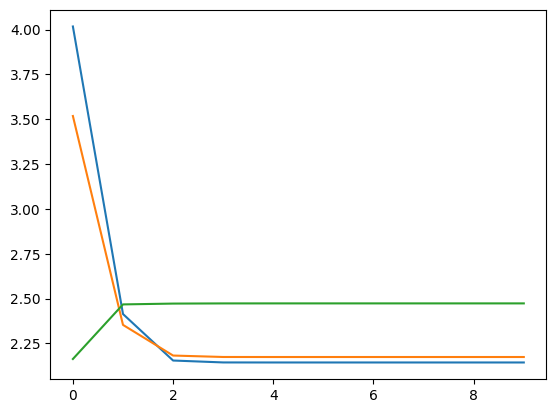

In [151]:
def get_state(L: int = 3, chi: int = 4, d_phys: int = 2, seed: int | None = None):
    if seed is not None:
        t.manual_seed(seed)
    Psi = [t.randn(d_phys, 1, chi, dtype=default_dtype, device=device)] + [t.randn(d_phys, chi, chi, dtype=default_dtype, device=device) for _ in range(L-2)] + [t.randn(d_phys, chi, 1, dtype=default_dtype, device=device)]
    return Psi

Psi = get_state()
Psi = to_canonical_form(Psi, form='A')
from copy import deepcopy
init_Psi = deepcopy(Psi)
result = find_nash_eq(Psi, H, alpha=500, trace_history=True, convergence_threshold=1e-16)
print(result['num_iters'])
print(f"final energy: {t.tensor(result['energy']).cpu().numpy()}")

plt.plot(t.tensor(result['energy_history']).cpu().numpy())
expl = batch_compute_exploitability(result['state'], H_all_in_one, num_samples=1000)
print(expl)

In [155]:
print(get_state_from_tensors(result['state']).reshape(8))

tensor([-0.0062,  0.2372, -0.1162,  0.0032, -0.0957,  0.0033, -0.0041, -0.9597],
       device='mps:0')


#### Legacy function with numpy

In [85]:
# Next method: using the function

def optimize_quantum_state_non_ti(psi, H, steps=1000, alpha=0.1, use_tqdm=True):
    L = len(psi.shape)
    Es = []
    psi_list = [psi]
    for n in tqdm(range(steps)) if use_tqdm else range(steps):
        # all_norm = einops.einsum(psi, psi.conj(), "d1 d2 d3, d1 d2 d3 -> ")
        # psi = psi / np.sqrt(all_norm)
        unitaries = []
        E = []
        for i in range(L):
            j = np.mod(i - 1, L)
            k = np.mod(i + 1, L)
            
            dE = np.tensordot(H[i], psi, axes=([4, 5, 3], [1, 2, 0]))
            dE = np.tensordot(psi.conj(), dE, axes=([j, k], [j, k]))
            
            E.append(np.trace(dE).real)
            dE = np.eye(2) - alpha * dE
            
            Y, _, Z = np.linalg.svd(dE)
            unitaries.append((Y @ Z).T.conj())
        
        Es.append(np.array(E))

        for i in range(L):
            psi = apply_u(unitaries[i], psi, [i])
        
        psi_list.append(psi)
            
    return np.stack(Es), psi_list

def apply_u(u,psi,idx):
    l = len(u.shape)//2
    psi = np.tensordot(u, psi, axes=(list(range(l)), idx))
    return np.moveaxis(psi, list(range(l)), idx)


#### Test this optimization procedure

In [156]:
result_2 = find_nash_eq(result['state'], H, max_iter=3000, alpha=0.05, convergence_threshold=1e-6, trace_history=True)

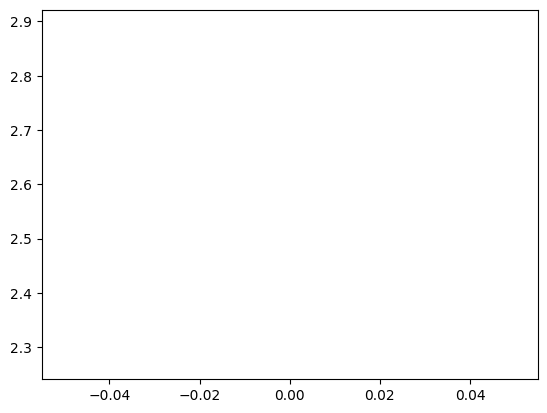

In [144]:
plt.plot(t.tensor(result_2['energy_history']).cpu().numpy())

100%|██████████| 1000/1000 [00:00<00:00, 11666.30it/s]

final energy: [2.14327913 2.1737577  2.47290411]


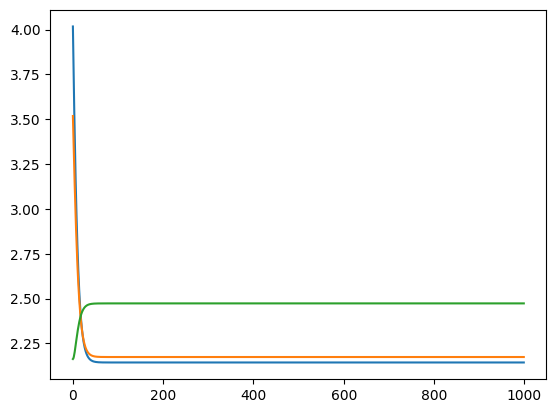

In [158]:
from opt_mps_fiducial_state import get_state_from_tensors

psi = get_state_from_tensors(init_Psi).cpu().numpy()
H_np = [h.cpu().numpy() for h in H]
Es, psi_list = optimize_quantum_state_non_ti(psi, H_np, steps=1000, alpha=0.06)
plt.plot(Es)
print(f"final energy: {Es[-1]}")


## Testing equilibrium-finding methods

In [44]:
from opt_mps_fiducial_state import get_state_from_tensors, apply_unitary, compute_energy
import sys
def find_nash_eq1(Psi, H, max_iter=10000, alpha=0.01, convergence_threshold=1e-6, trace_history=False):
    """
    Find Nash equilibrium using local gradients
    """
    L = len(Psi)
    _iter = 0
    converged = False
    
    # Convert everything to complex64 at the start for dtype consistency
    Psi = [psi.to(t.complex64) for psi in Psi]
    H = [h.to(t.complex64) for h in H]

    X = t.tensor([[0,1],[1,0]], dtype=t.complex64, device=device)
    Y = t.tensor([[0,-1j],[1j,0]], dtype=t.complex64, device=device)
    Z = t.tensor([[1,0],[0,-1]], dtype=t.complex64, device=device)

    E_history = []

    while _iter <= max_iter:
        unitaries = []
        psi = get_state_from_tensors(Psi)

        # compute the energies 
        E = compute_energy(Psi, H)
        E_history.append(E)

        dE_norms = []
        for i in range(L):
            j = (i - 1) % L
            k = (i + 1) % L
            
            # Get 2x2 gradient matrix at site i
            dE_matrix = t.tensordot(H[i], psi, dims=([4, 5, 3], [1, 2, 0]))
            dE_matrix = t.tensordot(psi.conj(), dE_matrix, dims=([j, k], [j, k]))
            
            # Decompose into Pauli basis (gradient lives in su(2))
            # The gradient matrix is Hermitian, extract anti-Hermitian part via Pauli decomposition
            dE_X = t.trace(dE_matrix @ X).imag  # Coefficient for X
            dE_Y = t.trace(dE_matrix @ Y).imag  # Coefficient for Y  
            dE_Z = t.trace(dE_matrix @ Z).imag  # Coefficient for Z
            
            dE = t.stack([dE_X, dE_Y, dE_Z])
            
            # Compute norm (dE is now real)
            dE_norm = t.sqrt(t.sum(dE**2))
            
            # Compute rotation angle
            coef = t.clamp(dE_norm, max=alpha)
            
            # Build unitary: U = exp(i*coef*n·σ) where n = dE/||dE||
            if dE_norm > 1e-10:
                n = dE / dE_norm  # Normalized direction
                unitaries.append(
                    t.eye(2, dtype=t.complex64, device=device) * t.cos(coef) +
                    1j * (n[0] * X + n[1] * Y + n[2] * Z) * t.sin(coef)
                )
            else:
                # No update if gradient is zero
                unitaries.append(t.eye(2, dtype=t.complex64, device=device))
            
            dE_norms.append(dE_norm)
        
        # Apply unitaries
        for i in range(L):
            Psi[i] = apply_unitary(unitaries[i], Psi[i])
        
        _iter = _iter + 1
        local_max_epl = sum(dE_norms).detach().cpu().numpy()

        if sum(dE_norms) < convergence_threshold:
            converged = True
            break

        if _iter % 100 == 0:
            print(f"Iteration {_iter}, local max epl: {local_max_epl}")
            sys.stdout.flush()
    
    if _iter > max_iter:
        print("Max iterations reached")

    result = {
        'converged': _iter < max_iter,
        'energy': E,
        'state': Psi,
        'num_iters': _iter,
        'local_max_epl': local_max_epl,
        'E_history': E_history,
    }

    return result

 

In [62]:
Psi = get_state(seed=2)
Psi = to_canonical_form(Psi, form='A')

result_2 = find_nash_eq1(Psi, H, max_iter=3000, alpha=0.001, convergence_threshold=1e-6, trace_history=True)

print(result_2['state'].to(t.float32))

Iteration 100, local max epl: 1.2752805948257446
Iteration 200, local max epl: 1.5308046340942383
Iteration 300, local max epl: 1.8236134052276611
Iteration 400, local max epl: 2.1556711196899414
Iteration 500, local max epl: 2.407443046569824


KeyboardInterrupt: 

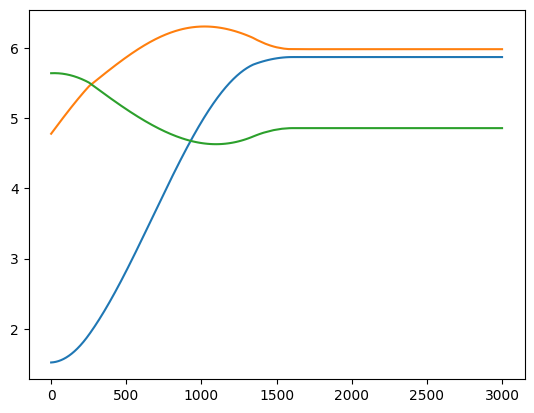

In [63]:
plt.plot(t.stack(result_2['E_history']).cpu().numpy())

In [67]:
Psi = [result_2['state'][i].to(t.float32) for i in range(len(result_2['state']))]
batch_compute_exploitability(Psi, H_all_in_one, num_samples=1000)


torch.float32


tensor([2.6221, 2.5287, 3.4656], device='mps:0')